# IFRS17 Simulation (Lapse Scenario)

If you're viewing this page as a static HTML page on https://lifelib.io, the same contents are also available [here on binder] as Jupyter notebook executable online (it may take a while to load)

To run this notebook and get all the outputs below, Go to the **Cell** menu above, and then click **Run All**.

[here on binder]: https://mybinder.org/v2/gh/fumitoh/lifelib/binder?filepath=lifelib%2Fprojects%2Fifrs17sim%2Fifrs17sim_charts_lapsescen.ipynb


## About this notebook

This notebook draws several waterfall charts that show how sources of change in IFRS17 accounts emerge when the actual lapse rate changes at a future point in time and future lapse rate assumptions from that point change accordingly for current-estimate liability valuations at future points. 

Those charts are:
* Actual cashflows
* Present value of expected cashflows
* CSM amortization
* IFRS17 Financial performance


A notebook for the baseline simulation is also available on [lifelib]. The baseline simulation assumes
that actual cashflow emerge exacltly as esimated at the beginning of simulation.

[ifrs17sim]: https://lifelib.io/projects/ifrs17sim.html
[lifelib]: https://lifelib.io

<div class="alert alert-warning">

**Warning:**

The primary purpose of this model is to showcase the capability of [lifelib] and its base system [modelx], and less attention has been paid to the accuracy of the model or the compliance with the accounting standards. 
At very least, following items are identified as over-simplification or lack of implementation.

<ul>
  <li>The timing of cashflows is either the beginning or end of each step.</li>
  <li>All expenses are included in insurance cashflows.</li>
  <li>Loss component logic is not yet incorporated, so `CSM` can be negative.</li>
  <li>Coverage unit is set to sum assured.</li>
  <li>The amortization schedule of acquisition cashflows is constant over time.</li>
  <li>All insurance cashflows are considered non-market sensitive, i.e. no TVOG is considered.</li>
  <li>Risk adjustment is not yet modeled.</li>
</ul>

</div>

[modelx]: http://docs.modelx.io

## How to use Jupyter Notebook
Jupter notebook enables you to run a Python script piece by piece. You can run each piece of code (called a "cell") by putting the cursor in the cell and pressing **Shift + Enter**, and get the output right below the input code of the cell. To learn more about Jupyter Notebook, [this tutorial] will help you. There are also plenty of other resources on the internet as Jupyter Notebook is quite popular.

[this tutorial]: https://nbviewer.jupyter.org/github/jupyter/notebook/blob/master/docs/source/examples/Notebook/Running%20Code.ipynb

You can play around with this notebook, by changeng input values and formulas, re-running code and checking how output tables and charts change accodingly.
Note that change in code in one cell may change the results of other cells. To reflect change in one cell on the output of other cells, the other cells need to be re-run after the change.

## Initial set-up

The first line `%matplotlib notebook`, is for specifying drawing mode.

The next few lines are import statements, by which functions defined in other modules become avaialbe in this script.

`ifrs17sim` and `draw_charts` modules are in the project directory of this project. To see what fiels are in the project directory, select **Open** from the **File** menu in the tool bar above.

In [1]:
%matplotlib notebook
import pandas as pd
import collections
import matplotlib.pyplot as plt
from draw_charts import draw_waterfall, get_waterfalldata, draw_actest_pairs

## Building the model

The next line is to create a model from `build` function defined in `ifrs17sim` module which has just been imported. 

By supplying `True` to `load_saved` parameter of the `build` function, the input data is read from `ifrs17sim.mx`, the 'pickled' file to save loading time. To read input from `input.xlsm`, call `build` with `load_saved=False` or without any parameter because `False` is the default value of `load_saved`. 

If you run this code multiple time, the previous model is renamed to `ifrs17sim_BAK*`, and a new model is created and returned as `model`.

In `model` thre is a space called `OuterProj` and other spaces. `OuterProj` is parametrized by Policy ID, i.e. each of the spaces with parameters corresponds to a projection of one policy. For example, `model.OuterProj[1]` return the projection of policy ID 1, `model.OuterProj[171]` return the projection of policy ID 171.

The first line below sets `proj` as a shorthand for the projection of Policy ID 1. 
You can change the sample policy by supplying some other ID.

In [2]:
import modelx as mx
model = mx.read_model("model")
proj = model.OuterProj[1]
inner = proj.InnerProj

## Adjusting lapse rates

By defalut, base lapse rates are read in from the input file. The initial rates are constant at 8%.

In [3]:
proj.asmp.SurrRate.to_frame(range(6))

,SurrRate
y,
0,0.08
1,0.08
2,0.08
3,0.08
4,0.08
5,0.08


In this model, adjustments to the base lapse rates can be made through the cells ``SurrRateMult``.
The cells ``SurrRateMult`` in outer and in inner spaces have have different formulas. 

For the outer actual simulation, as seen in the formula below, ``SurrRateMult`` is set to 1 by default, but can be overwritten by user input. If the user overwrite ``SurrRateMult(t)``, then the new value applies from ``t`` goint forward.

In [4]:
proj.asmp.SurrRateMult.formula

def SurrRateMult(t):
    """Surrender rate multiple (Default: 1)"""
    if t == 0:
        return 1
    else:
        return SurrRateMult(t-1)

For the inner projectins, ``SurrRateMult`` is set to the same value as the outer simulation at time 0.

At each step of outer simulation(``t0``), the lapse rates for the inner projection starting at ``t0``, are set to the lapse rate of the actual(outer) simulation applied in the previos period (from ``t0-1`` to ``t0``)

In [5]:
inner.asmp.SurrRateMult.formula

def SurrRateMult(t):
    """Surrender rate multiple (Default: 1)"""
    if t == 0:
        return 1
    else:
        return SurrRateMult(t-1)

We assumes that the actual lapse rate doubles from time 2, i.e. the beginning of the 3rd year, and continues to be doubled.
Accordingly, we assume we double our lapse rate assumption from the end of the 3rd yer, one year later later than the change in actual lapse.  

In [6]:
proj.asmp.SurrRateMult[1] = 1
proj.asmp.SurrRateMult[2] = 2       # Actual lapse rate from t=2 

inner[1].asmp.SurrRateMult[1] = 1
inner[2].asmp.SurrRateMult[2] = 1
inner[3].asmp.SurrRateMult[3] = 2   # The lapse assumption for estimated cashflows at t=3 and thereafter 

The figure below shows how underlying poicies change over time. 
The 3 columns in the fiture represents 3 cells, and filled lines denote actual(outer) while the dotted lines denote expected(inner). 
For each column, rows from the top to the bottom represent the time steps of the outer simulation, stating at time 0.

The leftmost column is the graph of policies in-force at the end of each period.
The column in the middle shows how ``SurrRateMult`` for actual lapse rate and estimated lapse rates change over time.
``SurrRateMult`` stays at time 0 and 1 (1st and 2nd rows). Then it doubles for the acutal at time 2 (3rd row), while the estimate stays still at 1 for 1 year. Then the estimate catches up the actual at time 3 (4th row).

The right most column show the movement in terms of the number of surrender policies.


<IPython.core.display.Javascript object>


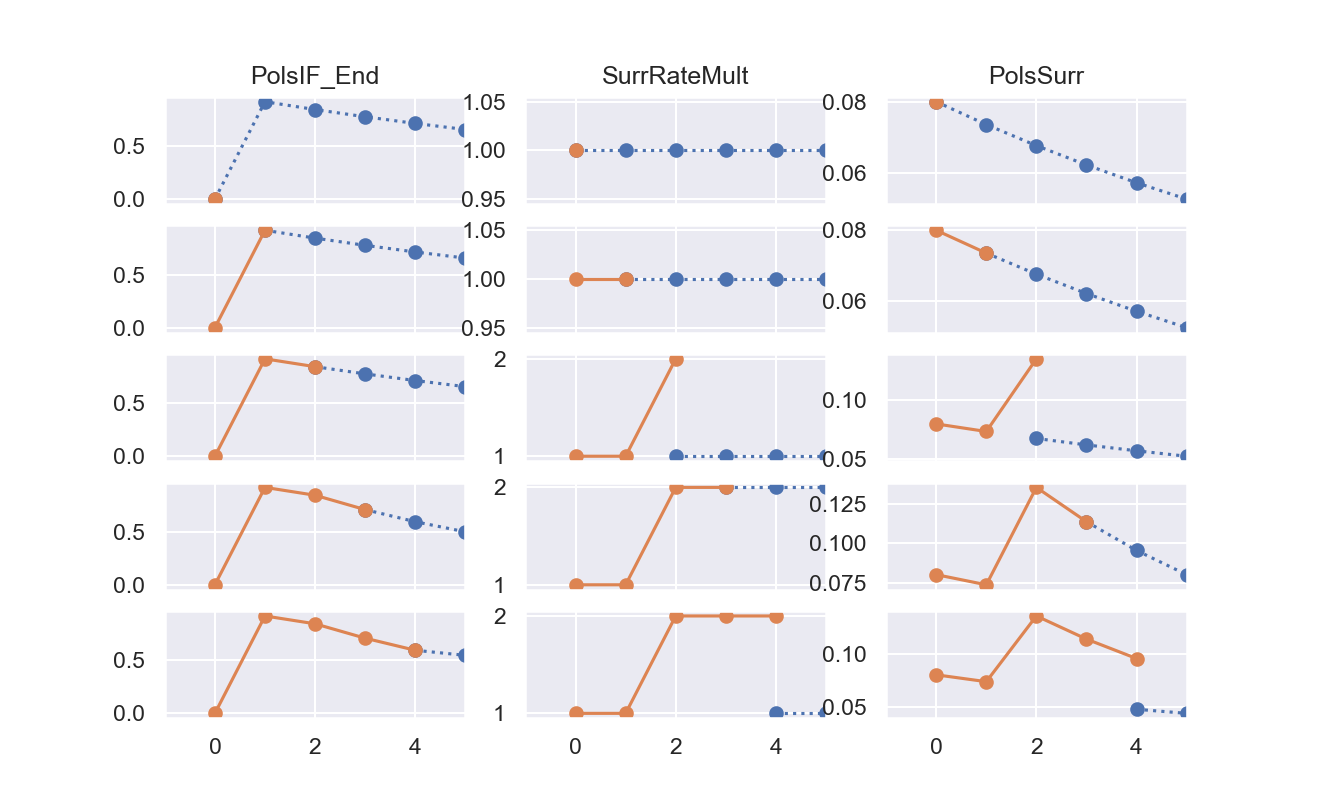

In [7]:
draw_actest_pairs(proj, inner, ['PolsIF_End', 'SurrRateMult', 'PolsSurr'], 5, 5)

## Actual cashflows

The code below generates a waterfall chart that simulates actual insurance cashflows that are assumed to be equal to the expected. The net asset balance is reset to zero at the end of each period, so the assets are equal to the liabilities at the beginning of each period. 
The assets are held as cash, and bear interest at the same rate as discount rate.

In [8]:
proj.IntAccumCF.formula

def IntAccumCF(t):
    """Intrest on accumulated cashflows"""
    return (AccumCF(t)
            + PremIncome(t)
            - ExpsTotal(t)) * DiscRate(t, 0)

In [9]:
actcf = get_waterfalldata(
            proj,
            items=['PremIncome',
                   'IntAccumCF',
                   'ExpsAcqTotal',
                   'BenefitTotal',
                   'ExpsMaintTotal',
                   'ActualNetCF'],
            length=4,
            reverseitems=['ExpsAcqTotal',
                          'BenefitTotal',
                          'ExpsMaintTotal'])
    
actcf

,PremIncome,IntAccumCF,ExpsAcqTotal,BenefitTotal,ExpsMaintTotal,ActualNetCF
t,,,,,,
0,3574.169909,-23.007341,-4072.250973,-556.898777,-1035.741699,-2113.728881
1,3286.309839,-15.774573,-164.315492,-575.782913,-952.324098,1578.112762
2,3021.518710,-10.000811,-151.075936,-661.304449,-875.591536,1323.545979
3,2536.214461,-4.600831,-126.810723,-614.423546,-734.957526,1055.421834


<IPython.core.display.Javascript object>


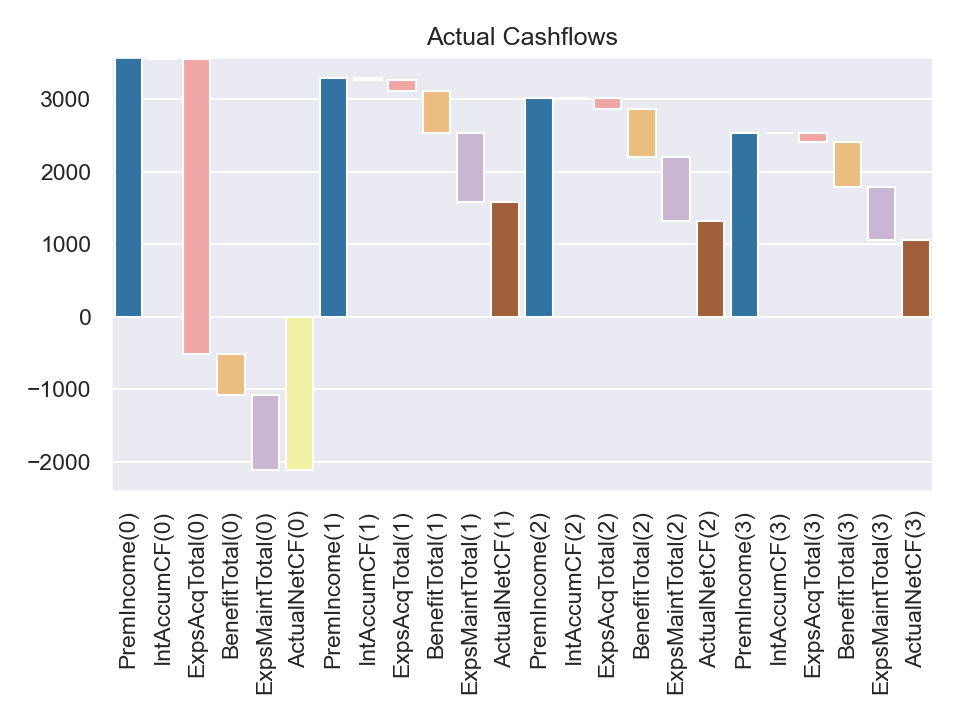

<AxesSubplot:title={'center':'Actual Cashflows'}>

In [10]:
draw_waterfall(actcf, stocks=[0, 5], title='Actual Cashflows')

## Present value of expected cashflows

The code below generate a waterfall chart that shows how the present value of expected insurance cashflows unwinds over time. 

The waterfall bars are disconected at t = 3, because we change the lapse assumption there. The present value of future cashflows decrease due to the decrease in future policies.

In [11]:
estcf = get_waterfalldata(
            proj,
            items=['PV_FutureCF',
                   'EstPremIncome',
                   'EstIntOnCF',
                   'EstAcqCashflow',
                   'EstClaim',
                   'EstExps'],
            length=4,
            reverseitems=['EstPremIncome'])

estcf

,PV_FutureCF,EstPremIncome,EstIntOnCF,EstAcqCashflow,EstClaim,EstExps
t,,,,,,
0,8954.018303,-3574.169909,157.317616,4072.250973,556.898777,1035.741699
1,11202.057458,-3286.309839,135.485808,164.315492,575.782913,952.324098
2,9743.655931,-3021.518710,116.232070,151.075936,591.028140,875.591536
3,5040.473472,-2536.214461,50.490409,126.810723,614.423546,734.957526


<IPython.core.display.Javascript object>


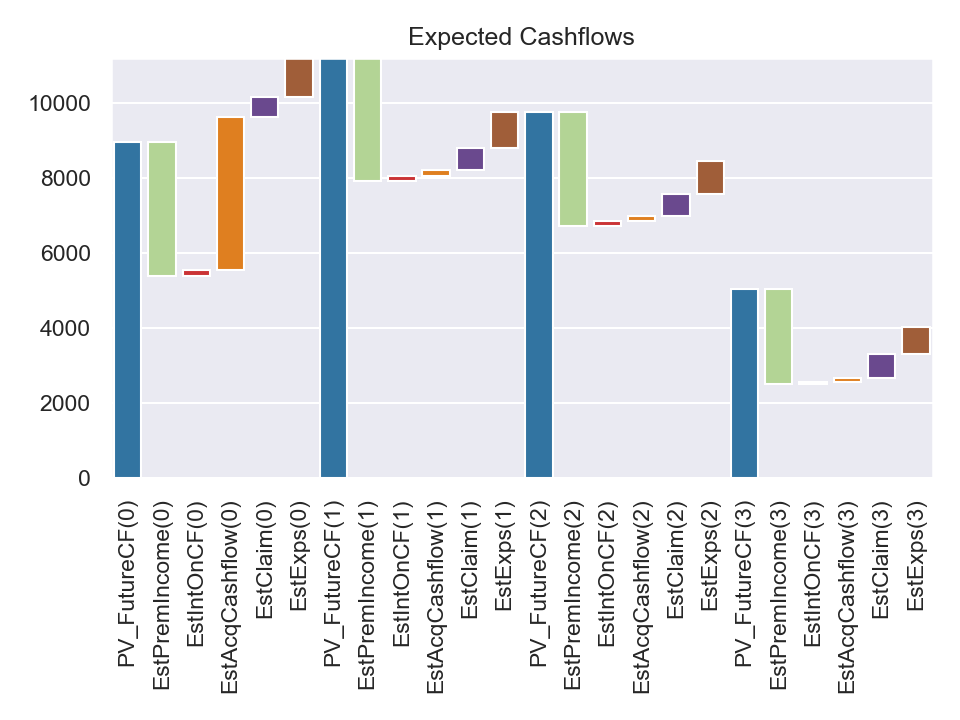

<AxesSubplot:title={'center':'Expected Cashflows'}>

In [12]:
draw_waterfall(estcf, title='Expected Cashflows')

## CSM amortization

The CSM amortization chart below depicts items that increase/decrease CSM balance. 

The adjustment to CSM for changes in fulfilment cashflows (``AdjCSM_FlufCF``) is negative in the 3rd period.
This offsets to a great extent the decrease in ``PV_FutureCF`` in the chart above (or increase in liability, if ``PV_FutureCF`` is negative unlike this sample, which is often the case) 

``AdjCSM_FlufCF`` takes the difference of ``PV_Cashflows`` with different parameters.

``PV_Cashflow(t+1, t+1, 0)`` starts projection at ``t+1`` into the future using the lapse assumption updated at ``t+1``, and discount the cashflows using the discount rate fixed at time zero, back to time ``t+1``.


``PV_Cashflow(t, t+1, 0)`` starts projection at ``t`` into the future using the lapse rate assumption before the change, and discount the cashflows using the discount rate fixed at time zero, back to time ``t+1``.

The sources of difference between these valuese are the difference in the number of policies in-force, and the difference in future laps rates, which impact projected policies in-force and cashflows from ``t+1``.


In [13]:
proj.AdjCSM_FlufCF.formula

def AdjCSM_FlufCF(t):
    """Adjustment to CSM for changes in fulfilment cashflows (44(c)->B96-B100)

    Warnings:
        Only B96(b) changes in PV of the future cashflows are implemented.

    TODO: Risk Adjustment is yet to be implemented. At the momement
    this adjustment only considers present value of future cashflows.

    TODO: Loss component for onerous contracts are yet to be implemented.
    At the momemnt this adjustment allows negative CSM.
    """

    return PV_Cashflow(t + 1, t + 1, 0) - PV_Cashflow(t, t + 1, 0)

In [14]:
csmrf = get_waterfalldata(
            proj, 
            items=['CSM',
                   'IntAccrCSM',
                   'AdjCSM_FlufCF',
                   'TransServices'],
            length=4,
            reverseitems=['TransServices'])

csmrf

,CSM,IntAccrCSM,AdjCSM_FlufCF,TransServices
t,,,,
0,8954.018303,134.310275,0.000000,-1107.579599
1,7980.748979,119.711235,0.000000,-1018.376245
2,7082.083968,106.231260,-3415.591431,-713.418589
3,3059.305208,45.889578,2060.665406,-757.771670


<IPython.core.display.Javascript object>


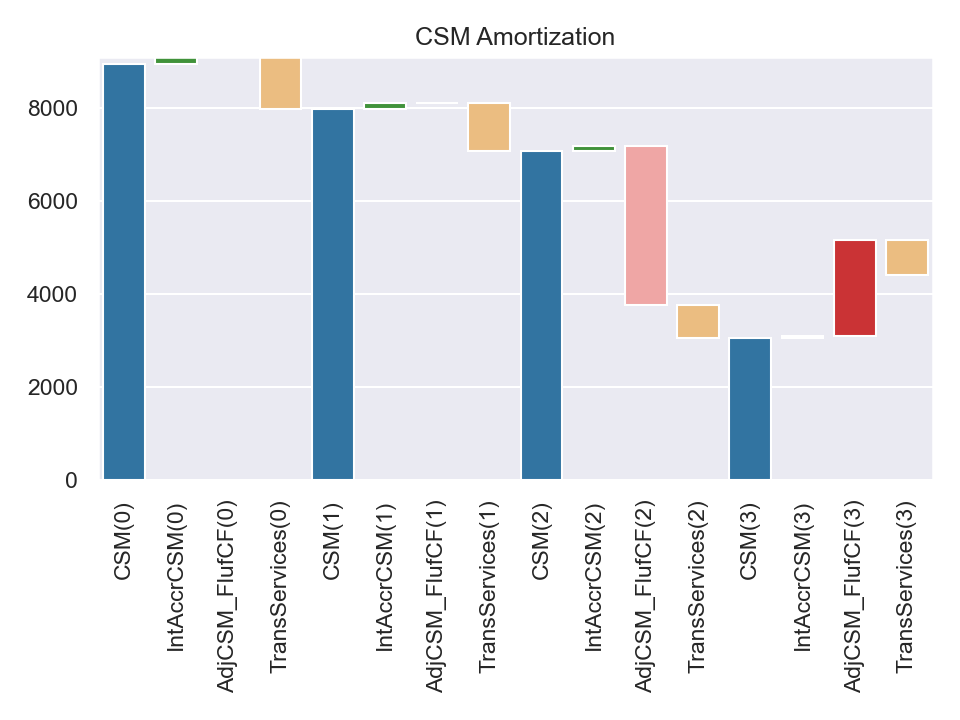

<AxesSubplot:title={'center':'CSM Amortization'}>

In [15]:
draw_waterfall(csmrf, title='CSM Amortization')

## IFRS17 Financial performance

The chart below simulates P&L accounts based on IFRS17 from the background data used to draw the charts above. The profit in each period is released and the outstanding net balance (`NetBalance`) is reset to zero.

The profit in the 3rd period is decreased due to the adverse change in lapse assumption, but its impact on the current profit is limited because of the offset between the change in CSM and the PV of future cashflows.

In [16]:
proj.InsurRevenue.formula

def InsurRevenue(t):
    """Insurance Revenue (82-85, B120-B125)"""
    return (EstClaim(t)
            + EstExps(t)
            + RelsRiskAdj(t)
            + TransServices(t)
            + AmortAcqCashflow(t)
            - AdjLCO_FulfCF(t))

In [17]:
proj.InsurServiceExps.formula

def InsurServiceExps(t):
    """Insurance Service Expense (103(b))"""
    return (IncurClaim(t)
            + IncurExps(t)
            + AmortAcqCashflow(t)
            + Incr_LossComp(t)
            - AdjLCO_FulfCF(t))

In [18]:
ifrspl = get_waterfalldata(
            proj,
            items=['InsurRevenue',
                   'InsurServiceExps',
                   'InsurFinIncomeExps',
                   'ProfitBefTax'],
            length=5,
            reverseitems=['InsurServiceExps'])
ifrspl

,InsurRevenue,InsurServiceExps,InsurFinIncomeExps,ProfitBefTax
t,,,,
0,3264.948734,-2157.369136,1.421085e-14,1107.579599
1,3065.729235,-2047.352990,-3.019807e-14,1018.376245
2,2657.446518,-2014.304238,1.776357e-15,643.142280
3,2507.881592,-1750.109922,2.664535e-15,757.771670
4,2048.161877,-1512.241430,0.000000e+00,535.920447


<IPython.core.display.Javascript object>


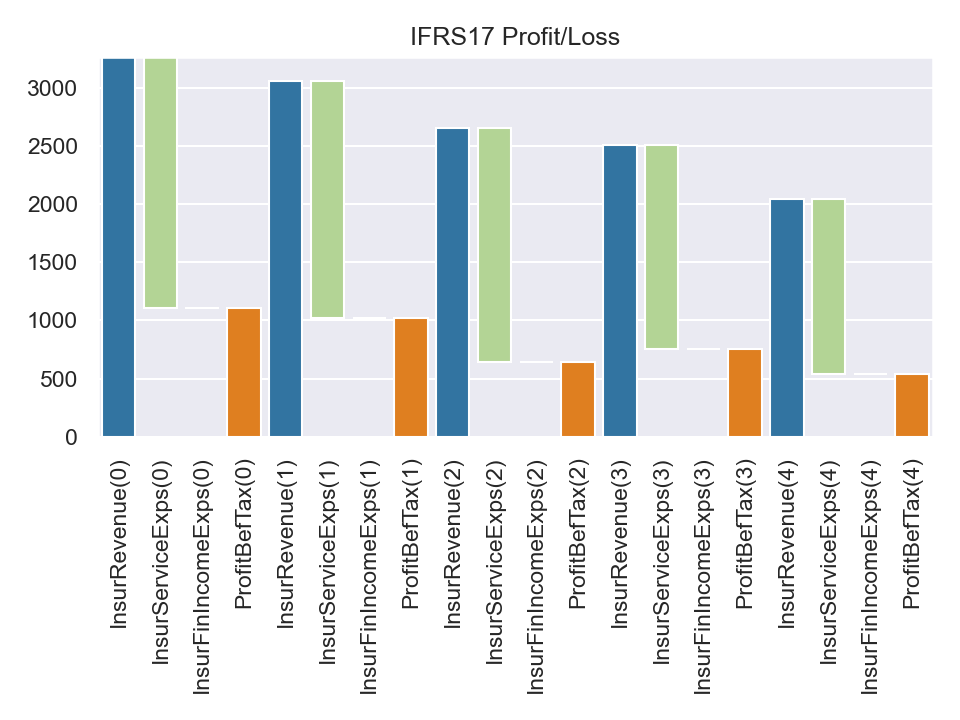

<AxesSubplot:title={'center':'IFRS17 Profit/Loss'}>

In [19]:
draw_waterfall(ifrspl, stocks=[0, 3], title='IFRS17 Profit/Loss')